In [13]:
import cv2
import os
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
from skimage.morphology import skeletonize
from skimage.util import invert
from nebula.common import to_scale_one, write_pickle, read_pickle, display, display_color, display2, display_list_color
from nebula.data.yg_ar.setup_data_image_hard import split_ar_anim_df

In [5]:
def display(frame):

    # display results
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

    ax.imshow(frame, cmap=plt.cm.gray)
    ax.axis('off')

    fig.tight_layout()
    plt.show()
    
    
def display2(f1, f2):
    
    # display results
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                             sharex=True, sharey=True)

    ax = axes.ravel()

    ax[0].imshow(f1, cmap=plt.cm.gray)
    ax[0].axis('off')
    ax[0].set_title('image 1', fontsize=20)

    ax[1].imshow(f2, cmap=plt.cm.gray)
    ax[1].axis('off')
    ax[1].set_title('image 2', fontsize=20)

    fig.tight_layout()
    plt.show()
    

def get_loc_frame_from_data(data, loc=0.5):
    count = data.get(cv2.CAP_PROP_FRAME_COUNT)
    f_loc = int((count-1) * loc)
    
    data.set(cv2.CAP_PROP_POS_FRAMES, f_loc)
    ret, frame = data.read()
    
    return frame
    
    
def get_loc_frame(path, loc=0.5):
    data = cv2.VideoCapture(path)
    return get_loc_frame_from_data(data, loc=loc)


def get_n_frames(path, n=8):
    data = cv2.VideoCapture(path)
    res = [get_loc_frame_from_data(data, loc=i/n) for i in range(n)]
    
    return res


def get_locs_frames(path, locs=[0.15, 0.5, 0.85]):
    data = cv2.VideoCapture(path)
    res = [get_loc_frame_from_data(data, loc=loc) for loc in locs]
    return res
    

def to_gray_one(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)


def to_gray(frames):
    res = [to_gray_one(f) for f in frames]
    return res


def crop_one(frame, top, bottom, left, right):
    return frame[top:-bottom, left:-right]


def crop(frames, top, bottom, left, right):
    res = [crop_one(f, top, bottom, left, right) for f in frames]
    return res


def save_frame(path, frame):
    cv2.imwrite(path, frame)
    

def read_gray_frame(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    
def to_jpg_name(file):
    return file.split(".")[0] + ".jpg"


def to_pickle_name(file):
    return file.split(".")[0] + ".pkl"


def get_files(dir, format=None):
    res = []
    for filename in os.listdir(dir):
        if format is None or filename.split(".")[-1] == format:
            res.append(filename)
    return res


def filename_to_labels(filename):
    
    filename = filename.split(".")[0]
    words = filename.split("_")
    
    orientation = words[-1]
    xangle = words[-2]
    yangle = words[-3]
    pants = words[-4]
    cloth = words[-6]
    hair = words[-8]
    action_type = words[-10]
    label = "_".join(words[:-10])
    
    return (
        orientation, 
        xangle, 
        yangle, 
        pants, 
        cloth, 
        hair, 
        action_type, 
        label
    )


def filename_to_labels_hard(filename):
    
    filename = filename.split(".")[0]
    words = filename.split("_")
    
    action = "_".join(words[:-12])
    action_type = words[-12]
    
    label_a = action
    label_at = "_".join([action, action_type])
    
    return (
        label_a,
        label_at,
        filename
    )


def read_pickle(dir):
    with open(dir, 'rb') as handle:
        b = pickle.load(handle)
    return b


def write_pickle(dir, data):
    with open(dir, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
def background_filter(path):
    locs= [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    frames = get_locs_frames(path, locs=locs)
    
    fgbg = cv2.createBackgroundSubtractorKNN(detectShadows=False, dist2Threshold=3000.0)

    res = []
    for f in frames:
        res.append(fgbg.apply(f))
        
    f1 = frames[-1]
    r1 = res[-1]
    
    return r1, f1

In [10]:
base_dir = 'C:/Users/aphri/Documents/t0002/pycharm/data/yg_ar/videos_medium'
file1 = "camel_1_hair_0_cloth_0_pants_2_Z868_XON3_YOP2_XAP53_YAP80.mp4"
file2 = "warrior_III_4_hair_2_cloth_3_pants_2_Z1038_XOP11_YON15_XAP58_YAP240.mp4"
file3 = "upward_dog_4_hair_1_cloth_2_pants_3_Z1091_XOP9_YON4_XAP3_YAP181.mp4"

In [23]:
res = []
for file in [file1, file2, file3]:
    r1, f1 = background_filter(osp.join(base_dir, file1))
    r1 = cv2.flip(r1, 1)
    res.append(f1)
    res.append(r1)

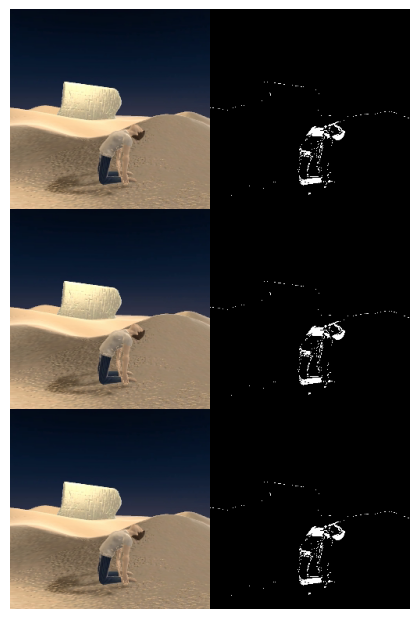

In [24]:
save_path = "C:/Users/aphri/Documents/t0002/pycharm/data/yg_ar/bgsub_images.png"
pad_dict = dict(
    left=0,
    bottom=0,
    right=1,
    top=1,
    wspace=0,
    hspace=0
)
display_list_color(res, 3, 2, 2, 2, pad_dict=pad_dict, save_path=save_path, is_gray=True)